In [149]:
!pip install aif360

  Using cached https://files.pythonhosted.org/packages/ff/7f/9d804d2348471c67a7d8b5f84f9bc59fd1cefa148986f2b74552f8573555/numpy-1.15.4-cp36-cp36m-manylinux1_x86_64.whl
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
ERROR: phik 0.9.8 has requirement pandas>=0.23.4, but you'll have pandas 0.23.3 which is incompatible.
ERROR: mxnet 1.4.1 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.4 which is incompatible.
ERROR: mizani 0.5.4 has requirement pandas>=0.23.4, but you'll have pandas 0.23.3 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.5.0 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.21.2 which is incompatible.
ERROR: fbprophet 0.5 has requirement pandas>=0.

In [150]:
!pip install BlackBoxAuditing

In [151]:
!pip install numpy --upgrade

  Using cached https://files.pythonhosted.org/packages/87/2d/e4656149cbadd3a8a0369fcd1a9c7d61cc7b87b3903b85389c70c989a696/numpy-1.16.4-cp36-cp36m-manylinux1_x86_64.whl
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
ERROR: phik 0.9.8 has requirement pandas>=0.23.4, but you'll have pandas 0.23.3 which is incompatible.
ERROR: mxnet 1.4.1 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.16.4 which is incompatible.
ERROR: mizani 0.5.4 has requirement pandas>=0.23.4, but you'll have pandas 0.23.3 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.5.0 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.16.4 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0

In [152]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals import joblib
from tqdm import tqdm


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

from aif360.datasets import BinaryLabelDataset  # To handle the data
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve, classification_report 
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

['hiring-prediction', 'models', 'hiring']


In [153]:
def confusion_matrix_plt(y_test_cm, y_pred_cm):
    y_test_legit = sum(y_test_cm==0)
    y_test_fraud = sum(y_test_cm==1)
    
    accuracy_cm = accuracy_score(y_test_cm, y_pred_cm)
    cfn_matrix = confusion_matrix(y_test_cm,y_pred_cm)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap=plt.cm.Blues,linewidths=0.5,annot=True,ax=ax)
    ax.set_title("Confusion Matrix \n Accuracy: %.2f%%" % (accuracy_cm * 100.0), fontsize=14)
    ax.set_xticklabels(['Rejected', 'Hired'], fontsize=10, rotation=90)
    ax.set_yticklabels(['Rejected', 'Hired'], fontsize=10, rotation=360)
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap=plt.cm.Blues,linewidths=0.5,annot=True,ax=ax)
    ax.set_title("Normalized Confusion Matrix \n Accuracy: %.2f%%" % (accuracy_cm * 100.0), fontsize=14)
    ax.set_xticklabels(['Rejected', 'Hired'], fontsize=10, rotation=90)
    ax.set_yticklabels(['Rejected', 'Hired'], fontsize=10, rotation=360)
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test_cm, y_pred_cm))

In [154]:
df = pd.read_csv('../input/hiring/hiring-dataset.csv')
training_df = pd.read_csv('../input/hiring-prediction/training_df.csv')
test_df = pd.read_csv('../input/hiring-prediction/test_df.csv')

In [155]:
protected_class = ['Unnamed: 0', 'Job Schedule', 'Job Type', 'Location', 'Job Field', 'Application Source Type', 
                   'Candidate Is Internal', 'Ethnicity Type', 'Candiate is disabled', 'Age (Years)',
                   'Candidate Gender', 'Manager Gender', 'Recruiter Gender', 'Hired']

X_train = training_df.drop(protected_class, axis=1)
y_train = training_df['Hired']
X_test = test_df.drop(protected_class, axis=1)
y_test = test_df['Hired']

In [156]:
# lr_model = LogisticRegression(penalty='l1', C=0.01, class_weight={0:1,1:60})
# lr_model.fit(X_train, y_train)
lr_model = joblib.load('../input/models/plain_lr_model.pkl') 
y_pred_lr = lr_model.predict(X_test)

In [157]:
joblib.dump(lr_model, 'plain_lr_model.pkl') 

['plain_lr_model.pkl']

In [158]:
# svc_model = SVC(kernel='linear', C=10, class_weight={0:1,1:60}, probability = True)
# svc_model.fit(X_train, y_train)
svc_model = joblib.load('../input/models/plain_svc_model.pkl') 
y_pred_svc = svc_model.predict(X_test)

In [159]:
joblib.dump(svc_model, 'plain_svc_model.pkl') 

['plain_svc_model.pkl']

# Fairness Metrics
## Gender

In [160]:
def dataset_wrapper(outcome, protected, label, protected_attribute, unprivileged_groups, privileged_groups,
                          favorable_label, unfavorable_label):
    """ A wraper function to create aif360 dataset from outcome and protected in numpy array format.
    """
    df = pd.DataFrame(data=outcome,
                      columns=[label])
    df[protected_attribute] = protected
    
    dataset = BinaryLabelDataset(favorable_label=favorable_label,
                                unfavorable_label=unfavorable_label,
                                df=df,
                                label_names=[label],
                                protected_attribute_names=[protected_attribute],
                                unprivileged_protected_attributes=unprivileged_groups)
    return dataset

In [161]:
favorable_label = 1
unfavorable_label = 0


p_train = training_df['Candidate Gender']
p_test = test_df['Candidate Gender']
unprivileged_groups = [{'Candidate Gender': 0}]
privileged_groups = [{'Candidate Gender': 1}]

In [162]:
original_training_dataset = dataset_wrapper(outcome=y_train, protected=p_train, 
                                         label='Hired', protected_attribute='Candidate Gender',
                                         unprivileged_groups=unprivileged_groups, 
                                         privileged_groups=privileged_groups,
                                         favorable_label=favorable_label,
                                         unfavorable_label=unfavorable_label)
original_test_dataset = dataset_wrapper(outcome=y_test, protected=p_test, 
                                        label='Hired', protected_attribute='Candidate Gender',
                                        unprivileged_groups=unprivileged_groups, 
                                        privileged_groups=privileged_groups,
                                        favorable_label=favorable_label,
                                        unfavorable_label=unfavorable_label)
plain_predictions_test_dataset_lr = dataset_wrapper(outcome=y_pred_lr, protected=p_test,
                                                 label='Hired', protected_attribute='Candidate Gender',
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                 unfavorable_label=unfavorable_label)
plain_predictions_test_dataset_svc = dataset_wrapper(outcome=y_pred_svc, protected=p_test,
                                                 label='Hired', protected_attribute='Candidate Gender',
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                 unfavorable_label=unfavorable_label)

In [163]:
def print_metrics(classified_metric, title):

    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)

    print(title)
    print("Test set: Classification accuracy = %f" % classified_metric.accuracy())
    print("Test set: Balanced classification accuracy = %f" % bal_acc)
    print("Test set: Statistical parity difference = %f" % classified_metric.statistical_parity_difference())
    print("Test set: Disparate impact = %f" % classified_metric.disparate_impact())
    print("Test set: Equal opportunity difference = %f" % classified_metric.equal_opportunity_difference())
    print("Test set: Average odds difference = %f" % classified_metric.average_odds_difference())
    print("Test set: Theil index = %f" % classified_metric.theil_index())
    print("Test set: False negative rate difference = %f" % classified_metric.false_negative_rate_difference())

In [164]:
classified_metric_nodebiasing_test_lr = ClassificationMetric(original_test_dataset,
                                         plain_predictions_test_dataset_lr,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
# print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")

classified_metric_nodebiasing_test_svc = ClassificationMetric(original_test_dataset,
                                         plain_predictions_test_dataset_svc,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
# print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")

In [165]:
def produce_metrics_dataframe(classifier, algorithm, classified_metric):
    
    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)
    
    results = {'Classifier': classifier,
            'Algorithm': algorithm,
            'Classification accuracy': classified_metric.accuracy(),
            'Balanced classification accuracy': bal_acc, 
            'Statistical parity difference': classified_metric.statistical_parity_difference(),
            'Disparate impact': classified_metric.disparate_impact(),
            'Equal opportunity difference': classified_metric.equal_opportunity_difference(),
            'Average odds difference': classified_metric.average_odds_difference(),
            'Theil index': classified_metric.theil_index(),
            'False negative rate difference': classified_metric.false_negative_rate_difference()
            }
    return results

results_lr = produce_metrics_dataframe('LR', '/', classified_metric_nodebiasing_test_lr)
results_svc = produce_metrics_dataframe('SVM', '/', classified_metric_nodebiasing_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df_lr, results_df_svc],ignore_index = True)

In [166]:
results_df

,Classifier,Algorithm,Classification accuracy,Balanced classification accuracy,Statistical parity difference,Disparate impact,Equal opportunity difference,Average odds difference,Theil index,False negative rate difference
0,LR,/,0.613567,0.578989,-0.042147,0.895355,-0.197214,-0.118851,0.066744,0.197214
1,SVM,/,0.565461,0.546808,-0.009229,0.978942,-0.054985,-0.031902,0.066509,0.054985


# Preprocessing Algorithms
## Reweighing
Reweighing is a preprocessing technique that weights the examples in each (group, label) combination differently to ensure fairness before classification. 

In [167]:
from aif360.algorithms.preprocessing import Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(original_training_dataset)
transf_training_dataset = RW.transform(original_training_dataset)

In [168]:
metric_orig_train = BinaryLabelDatasetMetric(original_training_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
metric_tranf_train = BinaryLabelDatasetMetric(transf_training_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Original training dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_train.mean_difference())
print("Transformed training dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_tranf_train.mean_difference())

Original training dataset:
Difference in mean outcomes between privileged and unprivileged groups = 0.002478
Transformed training dataset:
Difference in mean outcomes between privileged and unprivileged groups = 0.000000


In [169]:
metric_orig_test = BinaryLabelDatasetMetric(original_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
transf_test_dataset = RW.transform(original_test_dataset)
metric_transf_test = BinaryLabelDatasetMetric(transf_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Original testing dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_test.mean_difference())
print("Transformed testing dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_transf_test.mean_difference())

Original testing dataset:
Difference in mean outcomes between privileged and unprivileged groups = 0.002858
Transformed testing dataset:
Difference in mean outcomes between privileged and unprivileged groups = 0.000495


In [170]:
new_weights = pd.DataFrame({'Candidate Gender': p_train,
              'Hired': y_train,
              'Original_weight': np.ones(shape=(y_train.shape[0],)),
              'new_weight': transf_training_dataset.instance_weights})
# new_weights_01 = new_weights[(new_weights['Candidate Gender']==0)&(new_weights['Hired']==1)]
new_weights.iloc[[0, 5, 1, 253], :]

,Candidate Gender,Hired,Original_weight,new_weight
0,0,0,1.0,0.999418
5,0,1,1.0,1.038568
1,1,0,1.0,0.996909
253,1,1,1.0,1.246165


In [171]:
unbiased_lr = LogisticRegression(penalty='l1', C=0.01, class_weight={0:1,1:60})
unbiased_lr.fit(X_train, y_train, sample_weight=transf_training_dataset.instance_weights)
    
y_pred_transf_lr = unbiased_lr.predict(X_test)

In [172]:
unbiased_svc = SVC(kernel='linear', C=10, class_weight={0:1,1:60})
unbiased_svc.fit(X_train, y_train, sample_weight=transf_training_dataset.instance_weights)
    
y_pred_transf_svc = unbiased_svc.predict(X_test)

In [173]:
transf_predictions_test_dataset_lr = dataset_wrapper(outcome=y_pred_transf_lr, protected=p_test,
                                                  label='Hired', protected_attribute='Candidate Gender',
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                  unfavorable_label=unfavorable_label
                                                 )
transf_predictions_test_dataset_svc = dataset_wrapper(outcome=y_pred_transf_svc, protected=p_test,
                                                  label='Hired', protected_attribute='Candidate Gender',
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                  unfavorable_label=unfavorable_label
                                                 )

classified_metric_reweighing_test_lr = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
classified_metric_reweighing_test_svc = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)


In [174]:
# print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_reweighing_test_lr, "LR model - with reweighing - classification metrics")
# print('')
# print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_reweighing_test_svc, "SVM model - with reweighing - classification metrics")

In [176]:
results_lr = produce_metrics_dataframe('LR', 'Reweighing', classified_metric_reweighing_test_lr)
results_svc = produce_metrics_dataframe('SVM', 'Reweighing', classified_metric_reweighing_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

In [177]:
results_df

,Classifier,Algorithm,Classification accuracy,Balanced classification accuracy,Statistical parity difference,Disparate impact,Equal opportunity difference,Average odds difference,Theil index,False negative rate difference
0,LR,/,0.613567,0.578989,-0.042147,0.895355,-0.197214,-0.118851,0.066744,0.197214
1,SVM,/,0.565461,0.546808,-0.009229,0.978942,-0.054985,-0.031902,0.066509,0.054985
2,LR,Reweighing,0.425161,0.553059,-0.032460,0.945138,-0.180352,-0.105495,0.056905,0.180352
3,SVM,Reweighing,0.478261,0.552900,-0.005000,0.990512,-0.021994,-0.013496,0.061347,0.021994


## Disparate Impact Remover
Disparate impact remover is a preprocessing technique that edits feature values increase group fairness while preserving rank-ordering within groups

In [178]:
protected_class = ['Unnamed: 0', 'Job Schedule', 'Job Type', 'Location', 'Job Field', 'Application Source Type', 
                   'Candidate Is Internal', 'Ethnicity Type', 'Candiate is disabled', 'Age (Years)',
                   'Manager Gender', 'Recruiter Gender']
train = training_df.drop(protected_class, axis=1)
test = test_df.drop(protected_class, axis=1)

training_dataset = BinaryLabelDataset(favorable_label=favorable_label,
                            unfavorable_label=unfavorable_label,
                            df=train,
                            label_names=['Hired'],
                            protected_attribute_names=['Candidate Gender'],
                            unprivileged_protected_attributes=unprivileged_groups)
test_dataset = BinaryLabelDataset(favorable_label=favorable_label,
                            unfavorable_label=unfavorable_label,
                            df=test,
                            label_names=['Hired'],
                            protected_attribute_names=['Candidate Gender'],
                            unprivileged_protected_attributes=unprivileged_groups)

In [179]:
from aif360.algorithms.preprocessing import DisparateImpactRemover

DI = []
bal_acc = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(training_dataset)
    test_repd = di.fit_transform(test_dataset)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(penalty='l1', C=0.01, class_weight={0:1,1:60})
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    cm = ClassificationMetric(test_repd,
                             test_repd_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
    DI.append(cm.disparate_impact())
    TPR = cm.true_positive_rate()
    TNR = cm.true_negative_rate()
    acc = 0.5*(TPR+TNR)
    bal_acc.append(acc)

100%|██████████| 11/11 [01:27<00:00,  7.72s/it]


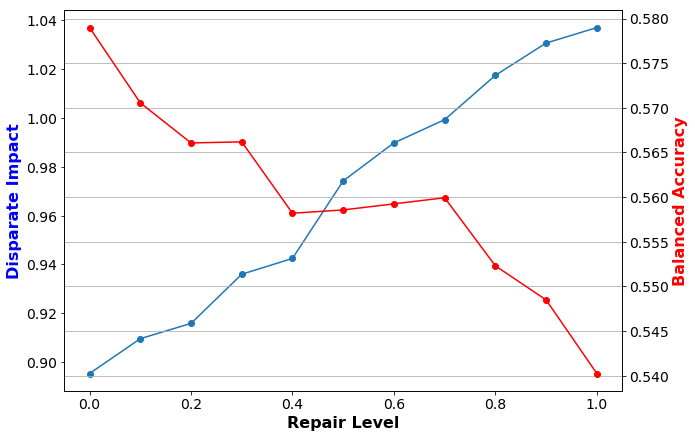

In [180]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(np.linspace(0, 1, 11), DI, marker='o')
ax1.set_xlabel('Repair Level', fontsize=16, fontweight='bold')
ax1.set_ylabel('Disparate Impact', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(np.linspace(0, 1, 11), bal_acc, marker='o', color='r')
ax2.set_ylabel('Balanced Accuracy', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [181]:
DIR = DisparateImpactRemover(repair_level=0.7)
transf_training_dataset = DIR.fit_transform(training_dataset)
transf_test_dataset = DIR.fit_transform(test_dataset)

In [182]:
train.columns.values.tolist()
train_dir = pd.DataFrame(np.hstack([transf_training_dataset.features, transf_training_dataset.labels]),columns=train.columns.values.tolist())
gender_0_orig = train.loc[train['Candidate Gender'] == 0]
gender_0_transf = train_dir.loc[train_dir['Candidate Gender'] == 0]
gender_0_orig.sort_values('iq')[:5]

,iq,ambition,interpersonal,creativity,fluid_iq,achievement,achievement_striving,agreeableness,benevolence,cog_flex,collectivism,core_self_evaluation,curiosity,extraversion,neuroticism,openness,self_discipline,total score,Candidate Gender,Hired
475,-2.523867,-0.058443,1.162129,1.565253,-2.566492,0.157705,-0.022463,0.220669,-0.023060,0.593768,0.027558,0.035711,0.708425,0.187241,-1.586673,0.690745,-0.075060,24.0,0,0
11408,-2.461585,2.536760,1.949881,1.574910,-2.503158,0.524222,0.793407,0.374383,0.470029,0.502494,-0.017363,1.085790,0.742682,0.974141,-1.419788,0.755005,0.940248,85.0,0,0
9193,-2.410946,-0.893404,2.104757,1.572786,-2.451664,0.378321,-0.109868,0.589963,0.597826,0.596006,0.253685,-0.520146,0.805739,0.983120,-1.243320,0.607306,-0.366640,12.0,0,0
4345,-2.383519,1.663584,0.859122,1.411257,-2.423774,0.402582,0.478741,-0.441921,0.107710,0.580242,-0.155167,0.838280,0.778228,1.284102,-0.521417,0.451531,0.537771,1.0,0,0
2656,-2.347964,1.706871,1.823016,1.517282,-2.387618,0.476132,0.483107,0.227669,0.352728,0.590544,0.003005,0.575505,0.698272,0.807008,-1.630551,0.644980,0.829120,18.0,0,0


In [183]:
gender_0_transf.sort_values('iq')[:5]

,iq,ambition,interpersonal,creativity,fluid_iq,achievement,achievement_striving,agreeableness,benevolence,cog_flex,collectivism,core_self_evaluation,curiosity,extraversion,neuroticism,openness,self_discipline,total score,Candidate Gender,Hired
475,-1.764319,-0.060867,1.165092,1.561275,-1.794116,0.158281,-0.039282,0.195419,-0.039433,0.592904,0.027912,0.035763,0.708266,0.181918,-1.627675,0.683173,-0.094837,23.0,0.0,0.0
11408,-1.764080,2.155468,1.957417,1.570157,-1.793873,0.520952,0.764779,0.352755,0.458723,0.501979,-0.013967,0.920318,0.743004,0.966642,-1.453635,0.750275,0.807428,85.0,0.0,0.0
9193,-1.764080,-0.794307,2.104564,1.569330,-1.793873,0.378023,-0.104990,0.582956,0.580618,0.595658,0.249210,-0.466120,0.806795,0.988279,-1.272298,0.604391,-0.407924,12.0,0.0,0.0
4345,-1.762933,1.628516,0.833411,1.399538,-1.792707,0.406827,0.476216,-0.245845,0.081804,0.580095,-0.156122,0.863311,0.779085,1.285921,-0.506337,0.427997,0.542960,1.0,0.0,0.0
2656,-1.759210,1.717834,1.836930,1.508650,-1.788920,0.471948,0.477384,0.205440,0.338067,0.590248,0.004337,0.579327,0.697880,0.803143,-1.649862,0.637723,0.797902,18.0,0.0,0.0


In [184]:
index = transf_training_dataset.feature_names.index('Candidate Gender')
X_tr = np.delete(transf_training_dataset.features, index, axis=1)
X_te = np.delete(transf_test_dataset.features, index, axis=1)
y_tr = transf_training_dataset.labels.ravel()

unbiased_lr = LogisticRegression(penalty='l1', C=0.01, class_weight={0:1,1:60})
unbiased_lr.fit(X_tr, y_tr)

y_pred_transf_lr = unbiased_lr.predict(X_te)

transf_predictions_test_dataset_lr = dataset_wrapper(outcome=y_pred_transf_lr, protected=p_test,
                                                  label='Hired', protected_attribute='Candidate Gender',
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                  unfavorable_label=unfavorable_label
                                                 )
classified_metric_dir_test_lr = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

In [185]:
unbiased_svc = SVC(kernel='linear', C=10, class_weight={0:1,1:60})
unbiased_svc.fit(X_tr, y_tr)
    
y_pred_transf_svc = unbiased_svc.predict(X_te)

transf_predictions_test_dataset_svc = dataset_wrapper(outcome=y_pred_transf_svc, protected=p_test,
                                                  label='Hired', protected_attribute='Candidate Gender',
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                  unfavorable_label=unfavorable_label
                                                 )
classified_metric_dir_test_svc = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

In [186]:
# print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_dir_test_lr, "LR model - with Disparate Impact Remover - classification metrics")
# print('')
# print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_dir_test_svc, "SVM model - with Disparate Impact Remover - classification metrics")
# print('')

In [187]:
results_lr = produce_metrics_dataframe('LR', 'Disparate Impact Remover', classified_metric_dir_test_lr)
results_svc = produce_metrics_dataframe('SVM', 'Disparate Impact Remover', classified_metric_dir_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

## Learning Fair Representations
Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes.

(error)

In [188]:
from aif360.algorithms.preprocessing import LFR

FR = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=unprivileged_groups)
FR = FR.fit(training_dataset)
transf_training_dataset = FR.transform(training_dataset)

LoweringError: Failed in object mode pipeline (step: object mode frontend)
Failed in object mode pipeline (step: object mode backend)
[1m[1m(<class 'numba.ir.Print'>, <numba.ir.Print object at 0x7f4808d86ef0>)
[1m
File "../../opt/conda/lib/python3.6/site-packages/aif360/algorithms/preprocessing/lfr_helpers/helpers.py", line 104:[0m
[1mdef LFR_optim_obj(params, data_sensitive, data_nonsensitive, y_sensitive,
    <source elided>
    if LFR_optim_obj.iters % print_inteval == 0:
[1m        print(LFR_optim_obj.iters, criterion)
[0m        [1m^[0m[0m
[0m
[0m[1m[1] During: lowering "print($392.3, criterion)" at /opt/conda/lib/python3.6/site-packages/aif360/algorithms/preprocessing/lfr_helpers/helpers.py (104)[0m
-------------------------------------------------------------------------------
This should not have happened, a problem has occurred in Numba's internals.

Please report the error message and traceback, along with a minimal reproducer
at: https://github.com/numba/numba/issues/new

If more help is needed please feel free to speak to the Numba core developers
directly at: https://gitter.im/numba/numba

Thanks in advance for your help in improving Numba!



## Optimized Preprocessing
Optimized preprocessing is a preprocessing technique that learns a probabilistic transformation that edits the features and labels in the data with group fairness, individual distortion, and data fidelity constraints and objectives

(not sure how to build the distortion function)

In [191]:
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

optim_options = {
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }
OP = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)
OP.fit(original_training_dataset)
transf_traning_dataset = OP.transform(original_training_dataset)
transf_test_dataset = OP.transform(original_test_dataset)

KeyError: 'distortion_fun'

# Inprocessing Algorithms
## Adversarial Debiasing
Adversarial debiasing is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary’s ability to determine the protected attribute from the predictions 

(The class imbalance may cause the bad performance of the technique. It may be better to use preprocessed dataset.)

In [192]:
from aif360.algorithms.inprocessing import AdversarialDebiasing

tf.reset_default_graph()
sess = tf.Session()

AD = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                          privileged_groups=privileged_groups,
                          scope_name="debiased_classifier", 
                          debias=True, sess=sess,
                          adversary_loss_weight=4300) 
AD.fit(training_dataset)
y_pred_AD = AD.predict(test_dataset)

epoch 0; iter: 0; batch classifier loss: 5.742355; batch adversarial loss: 0.712079
epoch 1; iter: 0; batch classifier loss: 0.185086; batch adversarial loss: 0.673211
epoch 2; iter: 0; batch classifier loss: 0.145899; batch adversarial loss: 0.676219
epoch 3; iter: 0; batch classifier loss: 11.169291; batch adversarial loss: 0.638925
epoch 4; iter: 0; batch classifier loss: 0.299612; batch adversarial loss: 0.692695
epoch 5; iter: 0; batch classifier loss: 0.494032; batch adversarial loss: 0.640561
epoch 6; iter: 0; batch classifier loss: 0.228794; batch adversarial loss: 0.673392
epoch 7; iter: 0; batch classifier loss: 0.537441; batch adversarial loss: 0.636285
epoch 8; iter: 0; batch classifier loss: 0.519011; batch adversarial loss: 0.648700
epoch 9; iter: 0; batch classifier loss: 0.849644; batch adversarial loss: 0.653063
epoch 10; iter: 0; batch classifier loss: 0.821159; batch adversarial loss: 0.639419
epoch 11; iter: 0; batch classifier loss: 0.301588; batch adversarial loss

In [193]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False, sess=sess,
                          adversary_loss_weight=4300)
plain_model.fit(training_dataset)
y_pred_plain = plain_model.predict(test_dataset)

epoch 0; iter: 0; batch classifier loss: 3.862413
epoch 1; iter: 0; batch classifier loss: 0.090786
epoch 2; iter: 0; batch classifier loss: 0.123179
epoch 3; iter: 0; batch classifier loss: 0.051642
epoch 4; iter: 0; batch classifier loss: 0.041203
epoch 5; iter: 0; batch classifier loss: 0.008139
epoch 6; iter: 0; batch classifier loss: 0.092585
epoch 7; iter: 0; batch classifier loss: 0.026058
epoch 8; iter: 0; batch classifier loss: 0.008699
epoch 9; iter: 0; batch classifier loss: 0.040240
epoch 10; iter: 0; batch classifier loss: 0.121730
epoch 11; iter: 0; batch classifier loss: 0.083982
epoch 12; iter: 0; batch classifier loss: 0.024784
epoch 13; iter: 0; batch classifier loss: 0.013729
epoch 14; iter: 0; batch classifier loss: 0.092368
epoch 15; iter: 0; batch classifier loss: 0.052294
epoch 16; iter: 0; batch classifier loss: 0.049388
epoch 17; iter: 0; batch classifier loss: 0.038762
epoch 18; iter: 0; batch classifier loss: 0.083240
epoch 19; iter: 0; batch classifier loss:

In [194]:
classified_metric_noadversarialdebiasing_test = ClassificationMetric(test_dataset, 
                                                 y_pred_plain,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
classified_metric_adversarialdebiasing_test = ClassificationMetric(test_dataset, 
                                                 y_pred_AD,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

# print_metrics(classified_metric_noadversarialdebiasing_test, "Plain model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_adversarialdebiasing_test, "model - with adversarial debiasing - classification metrics")

In [195]:
results_plain = produce_metrics_dataframe('/', 'no Adversarial Debiasing', classified_metric_noadversarialdebiasing_test)
results_ad = produce_metrics_dataframe('/', 'Adversarial Debiasing', classified_metric_adversarialdebiasing_test)
results_df_plain = pd.DataFrame(results_plain, index = [0])
results_df_ad = pd.DataFrame(results_ad, index = [0])
results_df = pd.concat([results_df, results_df_plain, results_df_ad],ignore_index = True)

## Prejudice Remover
Prejudice remover is an in-processing technique that adds a discrimination-aware regularization term to the learning objective.

(error)

In [196]:
from aif360.algorithms.inprocessing import PrejudiceRemover

PR = PrejudiceRemover(eta=1.0, sensitive_attr='Candidate Gender', class_attr='Hired')
PR.fit(training_dataset)
y_pred_PR = PR.predict(test_dataset)

IndexError: too many indices for array

# Postprocessing Algorithms
## Equality of Odds
Equalized odds postprocessing is a post-processing technique that solves a linear program to find probabilities with which to change output labels to optimize equalized odds

(It seems that the postprocessing doesn't work on my dataset. I'm still trying to figure out the reason.)

In [197]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing



pos_ind = np.where(lr_model.classes_ == test_dataset.favorable_label)[0][0]
dataset_orig_test_pred_lr = test_dataset.copy(deepcopy=True)
dataset_orig_test_pred_lr.scores = lr_model.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
dataset_orig_test_pred_lr.labels = y_pred_lr.reshape(-1,1)

pos_ind = np.where(svc_model.classes_ == training_dataset.favorable_label)[0][0]
dataset_orig_test_pred_svc = test_dataset.copy(deepcopy=True)
dataset_orig_test_pred_svc.scores = svc_model.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
dataset_orig_test_pred_svc.labels = y_pred_svc.reshape(-1,1)



EOP_lr = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
EOP_lr.fit(test_dataset, dataset_orig_test_pred_lr)
dataset_EOP_test_pred_lr = EOP_lr.predict(dataset_orig_test_pred_lr)

EOP_svc = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
EOP_svc.fit(test_dataset, dataset_orig_test_pred_svc)
dataset_EOP_test_pred_svc = EOP_svc.predict(dataset_orig_test_pred_svc)

In [198]:
print(dataset_orig_test_pred_svc.scores)
print('')
print(dataset_EOP_test_pred_svc.scores)

[[0.01677493]
 [0.01857348]
 [0.01220587]
 ...
 [0.0121299 ]
 [0.01641139]
 [0.01645025]]

[[0.01677493]
 [0.01857348]
 [0.01220587]
 ...
 [0.0121299 ]
 [0.01641139]
 [0.01645025]]


In [199]:
classified_metric_eqodds_test_lr = ClassificationMetric(test_dataset,
                                                 dataset_EOP_test_pred_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
classified_metric_eqodds_test_svc = ClassificationMetric(test_dataset, 
                                                 dataset_EOP_test_pred_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_eqodds_test_lr, "LR model - with Equalized Odds - classification metrics")
print('')
print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_eqodds_test_svc, "SVM model - with Equalized Odds - classification metrics")

Plain LR model - without debiasing - classification metrics
Test set: Classification accuracy = 0.613567
Test set: Balanced classification accuracy = 0.578989
Test set: Statistical parity difference = -0.042147
Test set: Disparate impact = 0.895355
Test set: Equal opportunity difference = -0.197214
Test set: Average odds difference = -0.118851
Test set: Theil index = 0.066744
Test set: False negative rate difference = 0.197214

LR model - with Equalized Odds - classification metrics
Test set: Classification accuracy = 0.984533
Test set: Balanced classification accuracy = 0.500000
Test set: Statistical parity difference = 0.000000
Test set: Disparate impact = nan
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000
Test set: Theil index = 0.015588
Test set: False negative rate difference = 0.000000

Plain SVM model - without debiasing - classification metrics
Test set: Classification accuracy = 0.565461
Test set: Balanced classification accuracy

In [200]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)

bef_avg_odds_diff_test = []
aft_avg_odds_diff_test = []
bef_bal_acc_test = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_test_pred_thresh = dataset_orig_test_pred_lr.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_EOP_test_pred_lr.copy(deepcopy=True)
    
    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    

    classified_metric_orig_test = ClassificationMetric(test_dataset,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))



    classified_metric_transf_test = ClassificationMetric(test_dataset,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))

100%|██████████| 25/25 [00:01<00:00, 18.36it/s]


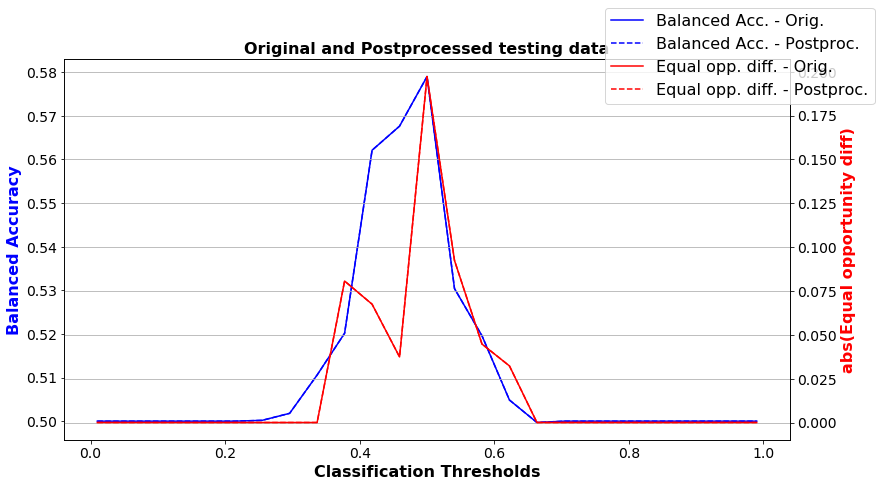

In [201]:
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)

In [202]:
results_lr = produce_metrics_dataframe('LR', 'Equalized Odds', classified_metric_eqodds_test_lr)
results_svc = produce_metrics_dataframe('SVM', 'Equalized Odds', classified_metric_eqodds_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

## Calibrated Equality of Odds
Calibrated equalized odds postprocessing is a post-processing technique that optimizes over calibrated classifier score outputs to find probabilities with which to change output labels with an equalized odds objective

In [203]:
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

CEOP_lr = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, cost_constraint = "fpr")
CEOP_lr.fit(test_dataset, dataset_orig_test_pred_lr)
dataset_CEOP_test_pred_lr = CEOP_lr.predict(dataset_orig_test_pred_lr)

CEOP_svc = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
CEOP_svc.fit(test_dataset, dataset_orig_test_pred_svc)
dataset_CEOP_test_pred_svc = CEOP_svc.predict(dataset_orig_test_pred_svc)

In [204]:
classified_metric_ceqodds_test_lr = ClassificationMetric(test_dataset, 
                                                 dataset_CEOP_test_pred_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
classified_metric_ceqodds_test_svc = ClassificationMetric(test_dataset, 
                                                 dataset_CEOP_test_pred_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

# print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_ceqodds_test_lr, "LR model - with Calibrated Equalized Odds - classification metrics")
# print('')
# print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_ceqodds_test_svc, "SVM model - with Calibrated Equalized Odds - classification metrics")

In [205]:
results_lr = produce_metrics_dataframe('LR', 'Calibrated Equalized Odds', classified_metric_ceqodds_test_lr)
results_svc = produce_metrics_dataframe('SVM', 'Calibrated Equalized Odds', classified_metric_ceqodds_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

In [206]:
# results_df

## Reject Option Classification
Reject option classification is a postprocessing technique that gives favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty.

In [207]:
from aif360.algorithms.postprocessing import RejectOptionClassification

ROC_lr = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
ROC_lr.fit(test_dataset, dataset_orig_test_pred_lr)
dataset_ROC_test_pred_lr = ROC_lr.predict(dataset_orig_test_pred_lr)

ROC_svc = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
ROC_svc.fit(test_dataset, dataset_orig_test_pred_svc)
dataset_ROC_test_pred_svc = ROC_svc.predict(dataset_orig_test_pred_svc)

In [208]:
classified_metric_roc_test_lr = ClassificationMetric(test_dataset, 
                                                 dataset_ROC_test_pred_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
classified_metric_roc_test_svc = ClassificationMetric(test_dataset, 
                                                 dataset_ROC_test_pred_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

# print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_roc_test_lr, "LR model - with Reject Option Classification - classification metrics")
# print('')
# print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_roc_test_svc, "SVM model - with Reject Option Classification - classification metrics")

In [209]:
results_lr = produce_metrics_dataframe('LR', 'Reject Option Classification', classified_metric_roc_test_lr)
results_svc = produce_metrics_dataframe('SVM', 'Reject Option Classification', classified_metric_roc_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

In [210]:
results_df

,Classifier,Algorithm,Classification accuracy,Balanced classification accuracy,Statistical parity difference,Disparate impact,Equal opportunity difference,Average odds difference,Theil index,False negative rate difference
0,LR,/,0.613567,0.578989,-0.042147,0.895355,-0.197214,-0.118851,0.066744,0.197214
1,SVM,/,0.565461,0.546808,-0.009229,0.978942,-0.054985,-0.031902,0.066509,0.054985
2,LR,Reweighing,0.425161,0.553059,-0.032460,0.945138,-0.180352,-0.105495,0.056905,0.180352
3,SVM,Reweighing,0.478261,0.552900,-0.005000,0.990512,-0.021994,-0.013496,0.061347,0.021994
4,LR,Disparate Impact Remover,0.614176,0.559922,-0.000286,0.999259,-0.164956,-0.081697,0.067355,0.164956
5,SVM,Disparate Impact Remover,0.571794,0.546149,0.117941,1.306410,0.025660,0.072394,0.066761,-0.025660
6,/,no Adversarial Debiasing,0.984655,0.503937,0.000000,NaN,0.000000,0.000000,0.015464,0.000000
7,/,Adversarial Debiasing,0.984533,0.500000,0.000000,NaN,0.000000,0.000000,0.015588,0.000000
8,LR,Equalized Odds,0.984533,0.500000,0.000000,NaN,0.000000,0.000000,0.015588,0.000000
9,SVM,Equalized Odds,0.984289,0.499876,0.000143,1.747400,0.000000,0.000073,0.015683,0.000000
